# Kiva collaborative filtering
***

### Imports

In [117]:
# essentials
import csv
import pandas as pd
import numpy as np
import itertools
import copy
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from scipy.sparse import csr_matrix, lil_matrix

# implicit framework
import implicit
from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)
from implicit.datasets.movielens import get_movielens
from implicit.evaluation import precision_at_k, train_test_split

# utilities
import codecs
import logging
import time
import tqdm

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime

# serialization
import pickle

In [2]:
pd.set_option('display.max_columns', 40)

In [4]:
%env MKL_NUM_THREADS=1
logging.basicConfig(level=logging.DEBUG)

env: MKL_NUM_THREADS=1


***
### Pickle loads

In [ ]:
loans_table = pickle.load(open("pickle/loans_table.p", "rb"))
funded_loans_table = pickle.load(open("pickle/funded_loans_table.p", "rb"))
funded_loan_ids_set = pickle.load(open("pickle/funded_loan_ids_set.p", "rb"))

In [ ]:
utility_matrix = pickle.load(open("pickle/utility_matrix.p", "rb"))

***
### Dataset reading

In [35]:
loans_table = pd.read_csv('additional-kiva-snapshot/loans.csv')
loans_table = loans_table.sort_values(by='raised_time')

In [36]:
funded_loans_table = loans_table[loans_table.status == 'funded']

In [37]:
START_DATE = '2013-10-01'
END_DATE = '2015-05-01'

# dates selected in 'Fairness-Aware Loan Recommendation for Microfinance Services' paper
# START_DATE = '2011-11-01'
# END_DATE = '2013-10-30'

mask = (funded_loans_table['raised_time'] > START_DATE) & (funded_loans_table['raised_time'] <= END_DATE)
funded_loans_table = funded_loans_table.loc[mask]
del mask

funded_loan_ids_set = set(funded_loans_table['loan_id'])

In [7]:
# pickle.dump(loans_table, open("pickle/loans_table.p", "wb"))
# pickle.dump(funded_loans_table, open("pickle/funded_loans_table.p", "wb"))
# pickle.dump(funded_loan_ids_set, open("pickle/funded_loan_ids_set.p", "wb"))

In [8]:
# free ram
# del loans_table
del funded_loans_table

In [9]:
loans = set()
lenders = set()
loans_lenders_dict = {}

with open('additional-kiva-snapshot/loans_lenders.csv', newline='', encoding="utf8") as csvfile:
    csv_reader = csv.reader(csvfile)
    line_num = 0
    for row in csv_reader:
        if line_num == 0:
            line_num += 1
            continue
        loan_id, lender_ids = row
        loan_id = int(loan_id)
        if loan_id not in funded_loan_ids_set:
            continue
        
        loans.add(loan_id)
        new_lenders = set(lender_ids.split(", "))
        loans_lenders_dict[loan_id] = new_lenders
        lenders.update(new_lenders)
        line_num += 1

loans = list(loans)
lenders = list(lenders)

print('Loans-lenders dict filled')

Loans-lenders dict filled


***
### Utility matrix creation
Rows of the matrix are loans and columns are lenders

In [10]:
lenders_reverse_index = {k: v for v, k in enumerate(lenders)}
utility_matrix = lil_matrix((len(loans), len(lenders)), dtype=np.float64)

In [11]:
for loan_index, loan in enumerate(loans):
    for lender in loans_lenders_dict[loan]:
        lender_index = lenders_reverse_index[lender]
        utility_matrix[loan_index, lender_index] = 1.0

print('Filled utility matrix')

Filled utility matrix


In [12]:
utility_matrix = utility_matrix.tocsr()

In [13]:
# pickle.dump(utility_matrix, open("pickle/utility_matrix.p", "wb"))

***
### Utility functions

In [13]:
MODELS = {
    "als":  AlternatingLeastSquares,
    "bpr": BayesianPersonalizedRanking,
}

In [14]:
def get_model(model_name):
    print("getting model %s" % model_name)
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if issubclass(model_class, AlternatingLeastSquares):
        params = {'factors': 16, 'dtype': np.float32, 'use_gpu': True}
    elif model_name == "bpr":
        params = {'factors': 63}
    else:
        params = {}

    return model_class(**params)

In [15]:
def train_model(model_name="als", alpha=40):    
    # create a model from the input data
    model = get_model(model_name)
    data_matrix = utility_matrix
    
    # if we're training an ALS based model, weight input by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # multiply positive inputs with alpha
        logging.debug("scaling matrix by alpha")
        data_matrix = (data_matrix*alpha).astype('double')
        
#         logging.debug("weighting matrix by bm25_weight")
#         data_matrix = bm25_weight(data_matrix)

        # also disable building approximate recommend index
        model.approximate_similar_items = False
        
    logging.debug("training model %s", model_name)
    start = time.time()
    model.fit(data_matrix)
    logging.debug("trained model '%s' in %0.2fs", model_name, time.time() - start)
    
    return model

In [16]:
def calculate_recommendations(model, output_filename, N=10):
    """ Generates loan recommendations for each lender in the dataset """

    # generate recommendations for each lender and write out to a file
    start = time.time()
    lenders_loans = utility_matrix.T.tocsr()
    with tqdm.tqdm(total=len(lenders)) as progress:
        with codecs.open(output_filename, "w", "utf8") as o:
            for lender_index, lender in enumerate(lenders):
                for loan_index, score in model.recommend(lender_index, lenders_loans, N=N):
                    o.write("%s\t%s\t%s\n" % (lender, loans[loan_index], score))
                progress.update(1)
    logging.debug("generated recommendations in %0.2fs", time.time() - start)

In [17]:
def apply_confidence(matrix, alpha=1, weight=None, epsilon=1, dtype='double'):
    matrix = matrix.copy()
    matrix.data = weight(matrix.data/epsilon) if weight is not None else matrix.data/epsilon
    matrix.data = (alpha * matrix.data).astype(dtype)
    return matrix

This is an experimental function for cleaning up test/train set:

In [18]:
# Removes users and items unknown to one matrix from the other one
def clean_matrices(train, test):
    nonzero_rows_train, nonzero_cols_train = train.nonzero()
    nonzero_rows_test, nonzero_cols_test = test.nonzero()
    
    nonzero_rows_train = np.unique(nonzero_rows_train)
    nonzero_cols_train = np.unique(nonzero_cols_train)
    nonzero_rows_test = np.unique(nonzero_rows_test)
    nonzero_cols_test = np.unique(nonzero_cols_test)
    
    rows_intersection = np.intersect1d(nonzero_rows_train, nonzero_rows_test)
    cols_intersection = np.intersect1d(nonzero_cols_train, nonzero_cols_test)

    # select only intersecting rows and columns
    new_train = train[rows_intersection][:, cols_intersection]
    new_test = test[rows_intersection][:, cols_intersection]
    
    # difference after cleanup
    diff_rows_train = train.shape[0] - new_train.shape[0]
    diff_cols_train = train.shape[1] - new_train.shape[1]
    diff_rows_test = test.shape[0] - new_test.shape[0]
    diff_cols_test = test.shape[1] - new_test.shape[1]
    
    print('Removed %d rows from train set.' % diff_rows_train)
    print('Removed %d columns from train set.' % diff_cols_train)
    print('Removed %d rows from test set.' % diff_rows_test)
    print('Removed %d columns from test set.' % diff_cols_test)
    
    return (new_train, new_test)

***
### Training model (example)

In [19]:
model = train_model(alpha=40, model_name="als")

getting model als


DEBUG:root:scaling matrix by alpha
DEBUG:root:training model als
DEBUG:implicit:Calculated transpose in 0.329s
DEBUG:implicit:Initialized factors in 0.5190677642822266
DEBUG:implicit:Running 15 ALS iterations
100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:06<00:00,  2.44it/s]
DEBUG:root:trained model 'als' in 9.65s


In [ ]:
# this function call runs for ~ 1hr over filtered 648,650 lenders on my setup
calculate_recommendations(model, "output.tsv", N=10)

***
# Implicit testing environment

This section is an usage example on the MovieLens dataset:

In [20]:
titles, ratings = get_movielens('20m')

# remove things < min_rating, and convert to implicit dataset
# by considering ratings as a binary preference only
ratings.data[ratings.data < 4.0] = 0
ratings.eliminate_zeros()
ratings.data = np.ones(len(ratings.data))

train, test = train_test_split(ratings)

model = AlternatingLeastSquares(use_gpu=True)
model.fit(train)

precision = precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
print('Precision @10: %f' % precision)

INFO:implicit:Using cached dataset at 'C:\Users\Denis\implicit_datasets\movielens_20m.hdf5'
DEBUG:implicit:Calculated transpose in 0.376s
DEBUG:implicit:Initialized factors in 0.6886570453643799
DEBUG:implicit:Running 15 ALS iterations
100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:20<00:00,  1.37s/it]
100%|████████████████████████████████████████████████████████████████████████▉| 138493/138494 [11:32<00:00, 200.00it/s]


Precision @10: 0.218911


Running precision_at_k evaluation method over a model trained on 'MovieLens 20M' dataset took around 10 minutes.

Usage on Kiva data:

In [20]:
coo_mat = utility_matrix.tocoo()
train, test = train_test_split(coo_mat)
# train, test = clean_matrices(train, test)

model = AlternatingLeastSquares(use_gpu=True)
model.fit(train)

DEBUG:implicit:Calculated transpose in 0.204s
DEBUG:implicit:Initialized factors in 1.9514274597167969
DEBUG:implicit:Running 15 ALS iterations
100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:19<00:00,  1.23s/it]


In [ ]:
precision = precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
#map_measure = mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)

  1%|▍                                                                        | 3520/648650 [00:18<1:02:14, 172.74it/s]

In [ ]:
print('Precision @10: %f' % precision)

Running the same precision_at_k evaluation method on the "same" model trained on filtered Kiva dataset takes around 1hr 15 mins.

## Experimental implementation of evaluation measures

Mean ROC AUC @ K:

In [19]:
def mean_roc_auc_at_k(model, train_user_items, test_user_items, K=10, show_progress=True):
    auc_list = []
    lenders_count, loans_count = train_user_items.shape
    start = time.time()
    
    with tqdm.tqdm(total=lenders_count) as progress:
        for lender_index in range(lenders_count):
            if test_user_items[lender_index, :].nnz == 0:
                continue
                
            lender_row = np.zeros(loans_count)
            for loan_index, score in model.recommend(lender_index, train_user_items, N=K):
                lender_row[loan_index] = score
            
            test_lender_row = test_user_items[lender_index, :].toarray().flatten()
            roc_auc = roc_auc_score(test_lender_row, lender_row)
            auc_list.append(roc_auc)
            progress.update(1)
            
    logging.debug("generated mean ROC AUC in %0.2fs", time.time() - start)
    return np.mean(auc_list)  

Mean precison AUC @ K:

In [20]:
def mean_prec_auc_at_k(model, train_user_items, test_user_items, K=10, show_progress=True):
    auc_list = []
    lenders_count, loans_count = train_user_items.shape
    start = time.time()
    
    with tqdm.tqdm(total=lenders_count) as progress:
        for lender_index in range(lenders_count):
            if test_user_items[lender_index, :].nnz == 0:
                continue
                
            lender_row = np.zeros(loans_count)
            for loan_index, score in model.recommend(lender_index, train_user_items, N=K):
                lender_row[loan_index] = score
            
            test_lender_row = test_user_items[lender_index, :].toarray().flatten()
            
            precision, recall, thresholds = precision_recall_curve(test_lender_row, lender_row, pos_label=1)
            prec_auc = auc(recall, precision)                
            auc_list.append(prec_auc)
            progress.update(1)
            
    logging.debug("generated mean Precision/Recall curve AUC in %0.2fs", time.time() - start)
    return np.mean(auc_list)  

Mean ROC AUC @ K second variant:

In [21]:
def mean_roc_auc_at_k2(model, train_user_items, test_user_items, K=10, show_progress=True):
    auc_list = []
    lenders_count, loans_count = train_user_items.shape
    start = time.time()
    
    with tqdm.tqdm(total=lenders_count) as progress:
        for lender_index in range(lenders_count):
            if test_user_items[lender_index, :].nnz == 0:
                continue
                
            lender_vect = model.user_factors[lender_index]
            liked = train_user_items[lender_index].indices

            scores = model.item_factors.dot(lender_vect)
            scores = np.delete(scores, liked)
            
            test_lender_row = test_user_items[lender_index, :].toarray().flatten()
            test_lender_row = np.delete(test_lender_row, liked)
            
            roc_auc = roc_auc_score(test_lender_row, scores)
            auc_list.append(roc_auc)
            progress.update(1)
            
    logging.debug("generated mean ROC AUC in %0.2fs", time.time() - start)
    return np.mean(auc_list)  

In [22]:
coo_mat = utility_matrix.tocoo()
train, test = train_test_split(coo_mat)
train_user_items = train.T.tocsr()
test_user_items = test.T.tocsr()
#test_user_items = utility_matrix.T.tocsr()

model = AlternatingLeastSquares()
model.fit(train)

# mean_prec_auc = mean_prec_auc_at_k(model, train_user_items, test_user_items, K=10)
# print('Mean Prec AUC score: ', mean_prec_auc)

DEBUG:implicit:Calculated transpose in 0.254s
DEBUG:implicit:Initialized factors in 3.5747082233428955
DEBUG:implicit:Running 15 ALS iterations
100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:18<00:00,  1.20s/it]


In [ ]:
mean_roc_auc = mean_roc_auc_at_k2(model, train_user_items, test_user_items, K=10)
print('Mean ROC AUC score: ', mean_roc_auc)

Running the above method call takes around 18 hours.

#### Eval methods test

In [24]:
movies, ratings = get_movielens("1m")
ratings.data[ratings.data < 4.0] = 0
ratings.eliminate_zeros()
ratings.data = np.ones(len(ratings.data))

train, test = train_test_split(ratings)

model = AlternatingLeastSquares(use_gpu=True)
model.fit(train)

# precision = precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
# map_measure = mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
mean_roc_auc = mean_roc_auc_at_k2(model, train.T.tocsr(), test.T.tocsr(), K=10)
print('Mean ROC AUC score: ', mean_roc_auc)

# mean_prec_auc = mean_prec_auc_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10)
# print('Mean Precision/Recall curve AUC score: ', mean_prec_auc)

INFO:implicit:Using cached dataset at 'C:\Users\Denis\implicit_datasets\movielens_1m.hdf5'
DEBUG:implicit:Calculated transpose in 0.016s
DEBUG:implicit:Initialized factors in 0.031241416931152344
DEBUG:implicit:Running 15 ALS iterations
100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:01<00:00, 13.59it/s]
 99%|████████████████████████████████████████████████████████████████████████████▍| 5998/6041 [00:12<00:00, 488.22it/s]
DEBUG:root:generated mean ROC AUC in 12.32s


Mean ROC AUC score:  0.8329382540437026


Training and evaluating the above model (on MovieLens 1M dataset) takes only around 12 seconds on my setup.

All these calculations proved computationally inefficient on Kiva dataset.

***
### Cross-validation implementation experiment
Implementing this showed to be computationally inefficient with current implementations of evaluation measures 

Implement Cross-validation following [this guide](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/).

In [25]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

In [26]:
def learning_curve(model, train, test, epochs, k=5, user_index=None):
    if not user_index:
        user_index = range(train.shape[0])
    prev_epoch = 0
    train_precision = []
    test_precision = []
    
    headers = ['epochs', 'p@k train', 'p@k test']
    print_log(headers, header=True)
    
    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train)
        else:
            model.fit_partial(train)
        train_precision.append(precision_at_k(model, train.T.tocsr(), train.T.tocsr(), K=k, num_threads=4))
        test_precision.append(precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=k, num_threads=4))
        row = [epoch, train_precision[-1], test_precision[-1]]
        print_log(row)
        prev_epoch = epoch
    return model, train_precision, test_precision

In [27]:
def grid_search_learning_curve(base_model, train, test, param_grid,
                               user_index=None, patk=5, epochs=range(2, 40, 2)):
    """
    "Inspired" (stolen) from sklearn gridsearch
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, test_patk = learning_curve(this_model, train, test,
                                                                epochs, k=patk, user_index=user_index)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk}})
    return curves

In [28]:
param_grid = {'num_factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e2],
              'alpha': [1, 10, 50, 100, 500, 1000]}

In [30]:
# curves = grid_search_learning_curve(model, new_train, new_test,
#                                     param_grid,
#                                     user_index=None,
#                                     patk=5)

In [ ]:
# pickle.dump(curves, open("pickle/curves.p", "wb"))

***
# Visualizations

C:\Users\Denis\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\Denis\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Users\\Denis\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('C:\\Users\\Denis\\Anaconda3\

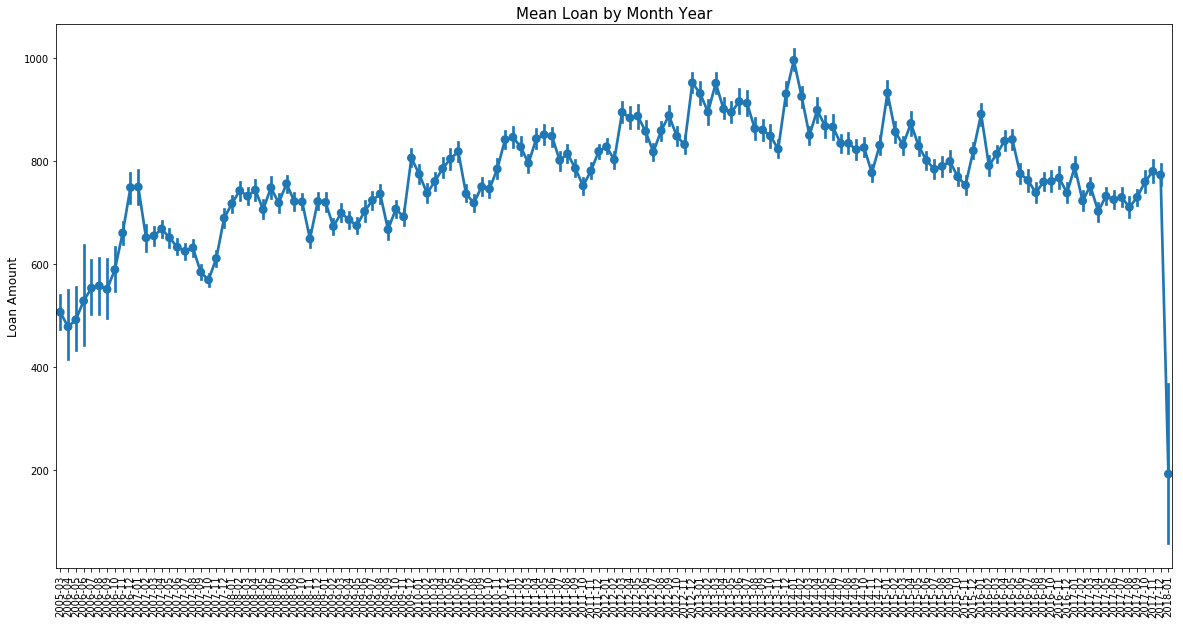

In [31]:
# START_DATE = '2000-01-01'
# END_DATE = '2015-01-01'

# mask = (loans_table['raised_time'] > START_DATE) & (loans_table['raised_time'] <= END_DATE)
# plot_data = loans_table.loc[mask]

plot_data = loans_table

plot_data['raised_time'] = pd.to_datetime(plot_data['raised_time'])
plot_data['date_month_year'] = plot_data['raised_time'].dt.to_period("M")

plt.figure(figsize=(20,10))
g1 = sns.pointplot(x='date_month_year', y='loan_amount', 
                   data=plot_data)
g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
g1.set_title("Mean Loan by Month Year", fontsize=15)
g1.set_xlabel("")
g1.set_ylabel("Loan Amount", fontsize=12)
plt.show()

#### Pandas dataset reading
###### (used only for data analysis purposes)

In [6]:
lenders_table = pd.read_csv('additional-kiva-snapshot/lenders.csv')

In [10]:
lenders_table

,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited
0,qian3013,Qian,NaN,NaN,NaN,1461300457,NaN,NaN,1.0,NaN,0
1,reena6733,Reena,NaN,NaN,NaN,1461300634,NaN,NaN,9.0,NaN,0
2,mai5982,Mai,NaN,NaN,NaN,1461300853,NaN,NaN,NaN,NaN,0
3,andrew86079135,Andrew,NaN,NaN,NaN,1461301091,NaN,NaN,5.0,Peter Tan,¸0
4,nguyen6962,Nguyen,NaN,NaN,NaN,1461301154,NaN,NaN,NaN,NaN,0
5,sirinapa6764,Sirinapa,NaN,NaN,NaN,1461301496,NaN,NaN,1.0,NaN,0
6,rene7585,Rene,NaN,NaN,NaN,1461301636,NaN,NaN,2.0,NaN,0
7,harald2826,Harald,NaN,NaN,NaN,1461301670,NaN,NaN,2.0,NaN,0
8,mehdi2903,Mehdi,NaN,NaN,NaN,1461301756,NaN,NaN,NaN,NaN,0
9,youchan8125,Youchan,NaN,NaN,NaN,1461301941,NaN,NaN,1.0,NaN,0


In [39]:
lenders = lenders_table['permanent_name']
lenders = lenders.dropna()
lenders

0                   qian3013
1                  reena6733
2                    mai5982
3             andrew86079135
4                 nguyen6962
5               sirinapa6764
6                   rene7585
7                 harald2826
8                  mehdi2903
9                youchan8125
10                   zhu2998
11              jennifer4328
12             aniruddha9724
13          duraimurugan4891
14                 chuan7668
15                 zhang2317
16                naresh2074
17                   min6557
18               weiting2757
19                   you2163
20                yibing3664
21                vidhya3861
22                 brave3842
23                charan2835
24               shalini8713
25         surendrakumar2666
26                  rank7715
27                   liz5177
28               jiaqing8074
29               qinghua8634
                 ...        
2349144         jeff82553550
2349145          brandon3139
2349146          ledizia8429
2349147       

In [19]:
loans_lenders_table = pd.read_csv('additional-kiva-snapshot/loans_lenders.csv')
loans_lenders_table

,loan_id,lenders
0,483693,"muc888, sam4326, camaran3922, lachheb1865, reb..."
1,483738,"muc888, nora3555, williammanashi, barbara5610,..."
2,485000,"muc888, terrystl, richardandsusan8352, sherri4..."
3,486087,"muc888, james5068, rudi5955, daniel9859, don92..."
4,534428,"muc888, niki3008, teresa9174, mike4896, david7..."
5,558112,"muc888, tristan7990, shivaun4955, sam44598568,..."
6,563395,"muc888, john38425073, trolltech4460, marianne8..."
7,575414,"muc888, dougal1825, dougal1825, jensdamsgaardv..."
8,578029,"muc888, rebecca3038, paul1853, paul1853, paul1..."
9,551251,"klaus5005, john70242429, john70242429, terry93..."


In [ ]:
loans_lenders_table

In [35]:
loans_lenders_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387432 entries, 0 to 1387431
Data columns (total 2 columns):
loan_id    1387432 non-null int64
lenders    1387432 non-null object
dtypes: int64(1), object(1)
memory usage: 21.2+ MB


In [11]:
loans_table = pd.read_csv('additional-kiva-snapshot/loans.csv')

In [18]:
df = loans_table[['loan_id', 'loan_name', 'funded_amount', 'loan_amount', 'status', 'activity_name', 'country_name', 'repayment_interval']]

#### Sparsity test

In [36]:
matrix_size = utility_matrix.shape[0]*utility_matrix.shape[1] # Number of possible interactions in the matrix
num_interactions = utility_matrix.nnz # Number of items interacted with
sparsity = 100*(1 - (num_interactions/matrix_size))
print('Sparsitiy: %f %%' % sparsity)

Sparsitiy: 99.996719 %


Average number of loans per lender:

In [37]:
unique, counts = np.unique(utility_matrix.tocoo().col, return_counts=True)
dict(zip(unique, counts))
np.mean(counts)

8.231642642411162

## Old testing environment

The train/test splitting script is used from [here](https://gist.github.com/tgsmith61591/ce7d614d7a0442f94cd5ae5d1e51d3c2).

In [ ]:
from collab_split import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

In [ ]:
coo_mat = utility_matrix.tocoo()

In [ ]:
users, items, ratings = coo_mat.row, coo_mat.col, coo_mat.data
users = LabelEncoder().fit_transform(users)
items = LabelEncoder().fit_transform(items)

Splitting the train/test samples 80/20.

In [ ]:
train, test = tts(users, items, ratings, train_size=0.8)

# Playground

In [ ]:
tr, te = clean_matrices(train, test)

In [ ]:
utility_matrix.shape

In [ ]:
lns_lndrs = pd.read_csv('C:/Users/Denis/Desktop/dipl rad/kiva_ds_csv/loans_lenders.csv')
lns_lndrs

In [46]:
lns = pd.read_csv('C:/Users/Denis/Desktop/dipl rad/kiva_ds_csv/loans.csv', skiprows=[0, 1, 2, 3, 4, 5])

In [47]:
lns = lns.sort_values(by='POSTED_TIME')
lns

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
1460734,283,Marco Tulio Morales,English,"My name is Tulio Morales, my business is the m...",NaN,425.0,425.0,funded,445.0,NaN,Cement,Construction,"Purchase of materials such as cement, sand, an...",HN,Honduras,Copan,not shared,NaN,USD,5.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,12.0,3,2,1,NaN,Marco Tulio Morales,male,true,monthly,field_partner
933214,253,Ruth Muthoni,English,Ruth is the Chairlady of Kandisi Wisdom Womenâ...,NaN,300.0,300.0,funded,413.0,NaN,Printing,Services,The loan applied for of USD 300 will be used t...,KE,Kenya,Ongata Rongai,not shared,NaN,USD,6.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,12.0,4,4,2,NaN,Ruth Muthoni,female,true,monthly,field_partner
1230032,258,Melecio,English,Don Melecio is a tailor who produces menâ€™s s...,NaN,500.0,500.0,funded,417.0,NaN,Tailoring,Services,Increase inventory,EC,Ecuador,Guayaquil,not shared,NaN,USD,7.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,1,14,7,NaN,Melecio,male,true,monthly,field_partner
645147,122,Joseph,English,Joseph is married with five children. He start...,NaN,500.0,500.0,funded,287.0,NaN,Animal Sales,Agriculture,Buy goats,UG,Uganda,Soroti,not shared,NaN,USD,1.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,5,22,11,NaN,Joseph,male,true,monthly,field_partner
1671869,254,Teresia,English,Teresia is married with 6 dependants. She is a...,NaN,1100.0,1100.0,funded,414.0,NaN,Furniture Making,Manufacturing,Given the loan of USD.1100 She will purchase a...,KE,Kenya,Nkoroi Kiserian,not shared,NaN,USD,6.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,12.0,11,4,2,NaN,Teresia,female,true,monthly,field_partner
796298,100,Charles,English,Charles is married and has 5 children. He has...,NaN,500.0,500.0,funded,258.0,NaN,Clothing Sales,Clothing,To increase the stock to 8 bails of used clot...,UG,Uganda,Soroti,not shared,NaN,USD,1.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,1,20,10,NaN,Charles,male,true,monthly,field_partner
944449,125,Mathayo,English,<i>This description was written by Richard Maz...,NaN,500.0,500.0,funded,297.0,NaN,Crafts,Arts,Purchase more stock,TZ,Tanzania,Dodoma,not shared,NaN,USD,1.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,7,2,1,NaN,Mathayo,male,true,monthly,field_partner
1639229,279,Peter,English,Peter has just been promoted to Foreman at the...,NaN,475.0,475.0,funded,441.0,NaN,Personal Housing Expenses,Housing,building materials,UG,Uganda,Kampala,not shared,NaN,USD,8.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,10.0,7,6,3,NaN,Peter,male,true,monthly,field_partner
398435,196,Blanca Lidia Suazo,English,I make my cheeses in my house with my family a...,NaN,600.0,600.0,funded,340.0,NaN,Cheese Making,Food,Purchase ingredients such as milk and packing ...,HN,Honduras,Siguatepeque,not shared,NaN,USD,5.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,4,4,2,NaN,Blanca Lidia Suazo,female,true,monthly,field_partner
398434,255,Nelly,English,Nelly is married with 5 dependants. She takes ...,NaN,300.0,300.0,funded,412.0,NaN,Used Clothing,Clothing,"As a result of increased clientele, she is to ...",KE,Kenya,Ongata Rongai,not 

In [48]:
plot_data = lns

plot_data['date_month_year'] = pd.to_datetime(plot_data['POSTED_TIME'])
# plot_data['date_month_year'] = plot_data['RAISED_TIME'].dt.to_period("M")
plot_data['date_month_year'] = plot_data['date_month_year'].values.astype('datetime64[M]')

In [49]:
plot_data

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,date_month_year
1460734,283,Marco Tulio Morales,English,"My name is Tulio Morales, my business is the m...",NaN,425.0,425.0,funded,445.0,NaN,Cement,Construction,"Purchase of materials such as cement, sand, an...",HN,Honduras,Copan,not shared,NaN,USD,5.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,12.0,3,2,1,NaN,Marco Tulio Morales,male,true,monthly,field_partner,2006-04-01
933214,253,Ruth Muthoni,English,Ruth is the Chairlady of Kandisi Wisdom Womenâ...,NaN,300.0,300.0,funded,413.0,NaN,Printing,Services,The loan applied for of USD 300 will be used t...,KE,Kenya,Ongata Rongai,not shared,NaN,USD,6.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,12.0,4,4,2,NaN,Ruth Muthoni,female,true,monthly,field_partner,2006-04-01
1230032,258,Melecio,English,Don Melecio is a tailor who produces menâ€™s s...,NaN,500.0,500.0,funded,417.0,NaN,Tailoring,Services,Increase inventory,EC,Ecuador,Guayaquil,not shared,NaN,USD,7.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,1,14,7,NaN,Melecio,male,true,monthly,field_partner,2006-04-01
645147,122,Joseph,English,Joseph is married with five children. He start...,NaN,500.0,500.0,funded,287.0,NaN,Animal Sales,Agriculture,Buy goats,UG,Uganda,Soroti,not shared,NaN,USD,1.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,5,22,11,NaN,Joseph,male,true,monthly,field_partner,2006-04-01
1671869,254,Teresia,English,Teresia is married with 6 dependants. She is a...,NaN,1100.0,1100.0,funded,414.0,NaN,Furniture Making,Manufacturing,Given the loan of USD.1100 She will purchase a...,KE,Kenya,Nkoroi Kiserian,not shared,NaN,USD,6.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,12.0,11,4,2,NaN,Teresia,female,true,monthly,field_partner,2006-04-01
796298,100,Charles,English,Charles is married and has 5 children. He has...,NaN,500.0,500.0,funded,258.0,NaN,Clothing Sales,Clothing,To increase the stock to 8 bails of used clot...,UG,Uganda,Soroti,not shared,NaN,USD,1.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,1,20,10,NaN,Charles,male,true,monthly,field_partner,2006-04-01
944449,125,Mathayo,English,<i>This description was written by Richard Maz...,NaN,500.0,500.0,funded,297.0,NaN,Crafts,Arts,Purchase more stock,TZ,Tanzania,Dodoma,not shared,NaN,USD,1.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,7,2,1,NaN,Mathayo,male,true,monthly,field_partner,2006-04-01
1639229,279,Peter,English,Peter has just been promoted to Foreman at the...,NaN,475.0,475.0,funded,441.0,NaN,Personal Housing Expenses,Housing,building materials,UG,Uganda,Kampala,not shared,NaN,USD,8.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,10.0,7,6,3,NaN,Peter,male,true,monthly,field_partner,2006-04-01
398435,196,Blanca Lidia Suazo,English,I make my cheeses in my house with my family a...,NaN,600.0,600.0,funded,340.0,NaN,Cheese Making,Food,Purchase ingredients such as milk and packing ...,HN,Honduras,Siguatepeque,not shared,NaN,USD,5.0,2006-04-16 07:10:50.000 +0000,NaN,2005-04-14 05:27:55.000 +0000,2005-03-31 06:27:55.000 +0000,6.0,4,4,2,NaN,Blanca Lidia Suazo,female,true,monthly,field_partner,2006-04-01
398434,255,Nelly,English,Nelly is married with 5 dependants. She takes ...,NaN,300.0,300.0,fund

In [134]:
def get_ticks(ax):
    prev_year = None
    ticks = []

    for item in ax.get_xticklabels():
        year = pd.to_datetime(item.get_text()).date().year
        if year != prev_year:
            prev_year = year
            ticks.append(year)
        else:
            ticks.append(None)
    return ticks

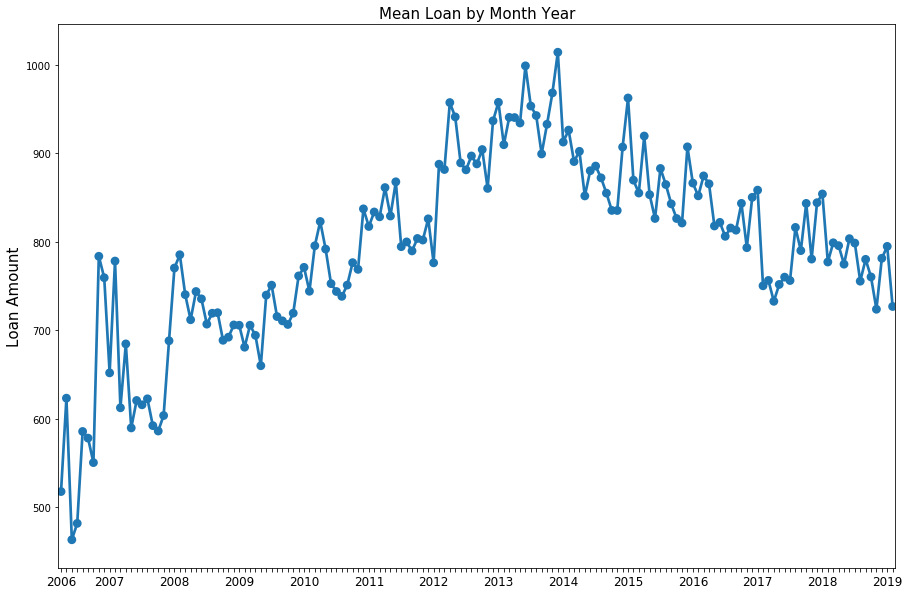

In [138]:
def myFormatter(x, pos):
    print(x, pos)
    return pd.to_datetime(x).strftime('%Y-%m')

plt.figure(figsize=(15,10))
ax = sns.pointplot(x='date_month_year', y='LOAN_AMOUNT', 
                   data=plot_data, ci=None)

ax.set_title("Mean Loan by Month Year", fontsize=15)
ax.set_xlabel("")
ax.set_ylabel("Loan Amount", fontsize=15)

ticks = get_ticks(ax)
ax.set_xticklabels(ticks, fontsize=12)

plt.show()

In [32]:
del plot_data

In [ ]:
with open("C:/Users/Denis/Desktop/dipl rad/kiva_ds_csv/loans.csv", encoding="utf8") as myfile:
    head = [next(myfile) for x in range(7)]
print(head)

In [32]:
lns.STATUS.value_counts()

funded         1592264
expired          76561
refunded          7529
fundRaising       6436
Name: STATUS, dtype: int64